# Supervised Learning Algorithms
In this notebook, several supervised learning algorithms are used to create binary classifiers that distinguish between benign and malicious traffics in the ids-2017 dataset. Hyperparameters are optimized to obtain a model with the best results and the models are compared

In [1]:
from notebook_utils import load_processed_dataset_2017, plot_confusion_matrix, metrics_report, upsample_dataset, extract_and_plot_metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, average_precision_score, make_scorer, precision_score, accuracy_score, confusion_matrix
from notebook_utils import upsample_dataset
%matplotlib inline
%load_ext autoreload
%autoreload 2
file_path = r"CIC-IDS-2017\CSVs\GeneratedLabelledFlows\TrafficLabelling\processed\ids2017_processed.csv"

In [2]:
X_train, Y_train, X_eval, Y_eval, X_test, Y_test, scaler = load_processed_dataset_2017(file_path)

In [3]:
performance_models = {}

In [4]:
import joblib

def save_model(model, model_name):
    file_path = f'models/{model_name}.pkl'
    joblib.dump(model, file_path)
    print(f'Model saved to {file_path}')

def load_model(model_name):
    file_path = f'models/{model_name}.pkl'
    model = joblib.load(file_path)
    print(f'Model loaded from {file_path}')
    return model

os.makedirs('models', exist_ok=True)

## 1. Naive Bayes

In [5]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
# Fit the model on the training data
nb_model.fit(scaler.transform(X_train), Y_train.is_attack)

GaussianNB()

Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9992    0.4412    0.6121    227310
           1     0.3048    0.9985    0.4670     55764

    accuracy                         0.5510    283074
   macro avg     0.6520    0.7199    0.5396    283074
weighted avg     0.8624    0.5510    0.5835    283074

Accuracy: 0.5509866677971131
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9992    0.4429    0.6137    227310
           1     0.3054    0.9985    0.4678     55765

    accuracy                         0.5523    283075
   macro avg     0.6523    0.7207    0.5407    283075
weighted avg     0.8625    0.5523    0.5850    283075

Accuracy: 0.5523447849509847


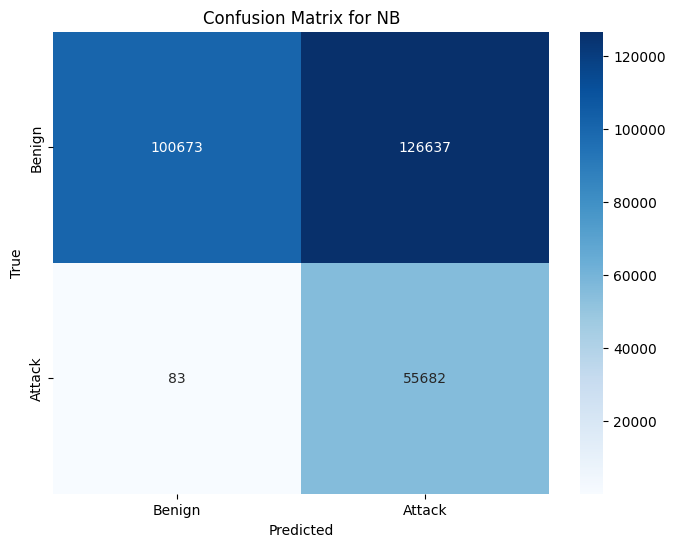

In [6]:
# Predict and evaluate on the evaluation set
y_pred_eval = nb_model.predict(scaler.transform(X_eval))
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test = nb_model.predict(scaler.transform(X_test))
performance_models["NB"] = metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("NB", Y_test, y_pred_test)

In [7]:
save_model(nb_model, 'nb_model')

Model saved to models/nb_model.pkl


## 3. K-Nearest Neighbors (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# Define the parameter grid for RandomizedSearchCV
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize the KNN Classifier
knn_model = KNeighborsClassifier()

# Define the scorer
scorer = make_scorer(precision_score)

# Initialize RandomizedSearchCV
random_search_knn = RandomizedSearchCV(estimator=knn_model, param_distributions=param_grid_knn, n_iter=20,
                                       scoring=scorer, n_jobs=-1, cv=2, verbose=2, random_state=42)

# Fit the model on the training data
random_search_knn.fit(X_train, Y_train.is_attack)

# Get the best model
best_knn_model = random_search_knn.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters for KNN:", random_search_knn.best_params_)

# Save the best model
save_model(best_knn_model, 'knn_model')

In [ ]:
# Predict and evaluate on the evaluation set
y_pred_eval_knn = best_knn_model.predict(scaler.transform(X_eval))
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval_knn, print_avg=False)

# Predict and evaluate on the test set
y_pred_test_knn = best_knn_model.predict(scaler.transform(X_test))
performance_models["KNN"] = metrics_report("Test", Y_test.is_attack, y_pred_test_knn, print_avg=False)
plot_confusion_matrix("KNN", Y_test.is_attack, y_pred_test_knn)

## 4. Quadratic Discriminant Analysis (QDA)

In [ ]:
# Define the parameter grid for RandomizedSearchCV
param_grid_qda = {
    'reg_param': [0.0, 0.1, 0.5, 1.0],
    'store_covariance': [True, False],
    'tol': [1e-4, 1e-3, 1e-2]
}

# Initialize the QDA Classifier
qda_model = QuadraticDiscriminantAnalysis()

# Initialize RandomizedSearchCV
random_search_qda = RandomizedSearchCV(estimator=qda_model, param_distributions=param_grid_qda, n_iter=20,
                                       scoring=scorer, n_jobs=-1, cv=2, verbose=2, random_state=42)

# Fit the model on the training data
random_search_qda.fit(X_train, Y_train.is_attack)

# Get the best model
best_qda_model = random_search_qda.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters for QDA:", random_search_qda.best_params_)

# Save the best model
save_model(best_qda_model, 'qda_model')

In [ ]:
# Predict and evaluate on the evaluation set
y_pred_eval_qda = best_qda_model.predict(scaler.transform(X_eval))
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval_qda, print_avg=False)

# Predict and evaluate on the test set
y_pred_test_qda = best_qda_model.predict(scaler.transform(X_test))
performance_models["QDA"] = metrics_report("Test", Y_test.is_attack, y_pred_test_qda, print_avg=False)
plot_confusion_matrix("QDA", Y_test.is_attack, y_pred_test_qda)

## 2. Support Vector Machine

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
import joblib
import os

# Apply PCA to reduce the number of features
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_eval_pca = pca.transform(X_eval)
X_test_pca = pca.transform(X_test)

# Define the LinearSVC model with chosen hyperparameters
linear_svc_model = LinearSVC(C=1, max_iter=10000, dual="auto")

# Fit the model on the training data
linear_svc_model.fit(X_train_pca, Y_train.is_attack)

# Save the model
save_model(linear_svc_model, 'linear_svc_binary_pca')

# Evaluate the model
# Predict on the evaluation set
y_pred_eval = linear_svc_model.predict(X_eval_pca)
performance_eval = metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test = linear_svc_model.predict(X_test_pca)
performance_models["LinearSVC"] = metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)

# Plot the confusion matrix
plot_confusion_matrix("LinearSVC", Y_test.is_attack, y_pred_test)

## 5. Conclusion

In [ ]:
extract_and_plot_metrics(performance_models)